## Preprocessing

### 数据库操作
从数据库中导入POI数据

In [1]:
import psycopg2

con = psycopg2.connect(database="prato", user="postgres", password="1218", host="127.0.0.1", port="5432")

# 找出所有含有功能信息的POI
cur = con.cursor()
cur.execute("select * from function where type <> \'null\'")
#cur.execute("select * from function where is_Chinese = True")
rows = cur.fetchall()

print("Database opened successfully")
print("Data Len = ", len(rows))
cur.close()
con.close()

Database opened successfully
Data Len =  10414


### GeoMath
提供坐标与经纬度之间的相互转换

In [2]:
# 基本静态变量
center = [43.878150000000005, 11.083850000000002]
equatorial_radius = 6378137.0
polar_radius = 6356752.3
earth_radius = 6367908.065252312
map_ratio = 0.7211005671900231

# 方法
import math

def calcEarthRadius(lat):
    global earth_radius
    global equatorial_radius
    global polar_radius
    lat = math.radians(lat)
    
    a = equatorial_radius
    b = polar_radius

    ta = a * math.cos(lat)
    tb = b * math.sin(lat)

    earth_radius = math.sqrt((ta * a * ta * a + tb * b * tb * b) / (ta * ta + tb * tb))


def haversineDistance(lat1, lng1, lat2, lng2):
    calcEarthRadius((lat1+lat2)/2)

    dlat = math.radians(lat2 - lat1)
    dlng = math.radians(lng2 - lng1)

    a = math.sin(dlat/2)*math.sin(dlat/2) + math.sin(dlng/2)*math.sin(dlng/2)*math.cos(lat1)*math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))


def latLngToXY(lat, lng):
    global map_ratio
    dist = haversineDistance(lat, lng, center[0], center[1])
    y = math.radians(lat - center[0])
    xp = math.radians(lng - center[1])
    
    if(map_ratio == 0.0):
        yp = math.log(math.tan(math.pi / 4.0 + math.radians(lat) / 2.0)) - math.log(math.tan(math.pi/4.0 + math.radians(center[0]) / 2.0))
        map_ratio = y/yp

    x = map_ratio * xp
    
    return earth_radius * x, earth_radius * y
    

def xyToLatLng(x, y):
    global map_ratio
    lat = math.degrees(y / earth_radius) + center[0]
    x /= map_ratio
    lng = math.degrees(x / earth_radius) + center[1]

    return lat, lng

# 计算地球坐标
calcEarthRadius(center[0])


# 检查经纬度转换是否正确
print(earth_radius)
x, y = latLngToXY(43.831, 11.0202)
print(x, y)
x, y = latLngToXY(43.9253, 11.1475)
print(x, y)

6367908.065252312
-5101.160603307125 -5240.303600544768
5101.146521771683 5240.289134910398


### 数据转换
将数据库中得到的row数据整理为类和对象列表

In [3]:
class Gpoi:
    def __init__(self, placeid, x, y, funtion):
        self.placeid = placeid
        self.x = x
        self.y = y
        self.type = funtion
        
    def __lt__(self, other):
        return self.x < other.x
    

colorDict = {
    'transport': (102, 102, 255),
    'government': (102, 153, 255),
    'health': (102, 204, 255),
    'education': (102, 255, 255),
    'religious': (102, 255, 204),
    'civic': (102, 255, 153),
    'sport': (102, 255, 102),
    'service': (153, 255, 102),
    'beauty': (204, 255, 102),
    'entertain': (255, 255, 102),
    'retail': (255, 204, 102),
    'hotel': (255, 153, 102),
    'food': (255, 102, 102)
}

In [4]:
p = []
for row in rows:
    x, y = latLngToXY(row[1], row[2])
    if('null' in row[7]):
        continue
    p.append(Gpoi(row[0].strip(), x, y, row[7].strip()))

p = sorted(p)

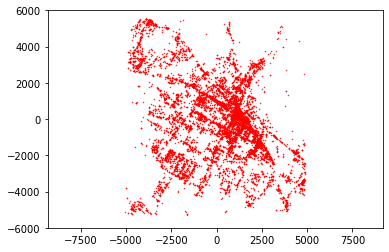

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.array([q.x for q in p])
y = np.array([q.y for q in p])
plt.scatter(x, y, s=0.2, c='r')

plt.axis("equal")
plt.ylim(-6000, 6000)

plt.show()

In [36]:
import copy
import bisect
import uuid
from PIL import Image, ImageDraw

step = 10
num = 9
y_size = step*num   #90
x_size = y_size*3   #270

def rangeAABB(pt, ranga, rangb):
    t = copy.deepcopy(pt)

    ox, oy = pt.x, pt.y
    t.x -= ranga
    left = bisect.bisect_left(p, t)
    t.x += ranga*2
    right = bisect.bisect_left(p, t)

    partP = p[left:right]

    ppartP = []
    ppartP.append(pt)
    for q in partP:
        if(q.x < ox+rangb and q.y < oy+rangb and ox > ox-rangb and oy > oy-rangb):
            continue
        if (q.y < oy+ranga and q.y > oy-ranga):
            ppartP.append(q)
    
    return ppartP, ox-ranga, oy-ranga



def drawAABB(ppartP, lbx, lby, size, path):
    global cntImgs
    global mapCSV

    rng = 2

    f = Image.new('RGB', (size//rng, size//rng), (0, 0, 0))
    draw = ImageDraw.Draw(f)

    for pt in ppartP:
        xx = (pt.x - lbx)//step * step//rng
        yy = size//rng - ((pt.y - lby)//step + 1) * step // rng

        # print(xx, yy)
        draw.rectangle((xx, yy, xx + step//rng-1, yy + step//rng-1), fill=colorDict[pt.type])

    arr = np.asarray(f)
    
    fname = uuid.uuid1()
    f.save('./data/{}/{}.jpg'.format(path, fname))
    mapCSV.append([cntImgs, fname])
    return arr

42
729


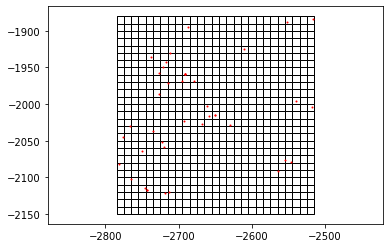

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


ppartP, lbx, lby = rangeAABB(p[1314], x_size/2, 0)
print(len(ppartP))
rt = []

for i in range(27):
    for j in range(27):
        rt.append(Rectangle((lbx+i*step, lby+j*step),10,10))

pc = PatchCollection(rt,facecolors='w', alpha=1,
                         edgecolor='k')

print(len(rt)) 


fig, ax = plt.subplots(1)
ax.add_collection(pc)


x = np.array([q.x for q in ppartP])
y = np.array([q.y for q in ppartP])
ax.scatter(x, y, s=1, c='r')
ax.axis("equal")

plt.show()

### 生成训练数据X

In [1]:
from time import time
cntImgs = 0
mapCSV = []
# data = np.zeros((1, x_size, x_size, 3))
size = x_size
pathname = 'X_270_270'

flag = True


lastTime = time()
for q in p:
    # if(cntImgs > 60):
    #     break
    cntImgs += 1
    ppartP, lbx, lby = rangeAABB(q, x_size/2, y_size/2)
    if(len(ppartP) == 1):
        continue
    
    arr = drawAABB(ppartP, lbx, lby, size, pathname)

    if(cntImgs % 500 == 0):
        print("Progress...{}/{}, {} seconds".format(cntImgs, len(p), time()-lastTime))
        lastTime = time()

# np.save('./data/{}.npy'.format(pathname), data)
# print("Total Len", len(p))
# print("Finish filter...Data size = ", data.shape[0])

import csv
with open('./data/{}.csv'.format(pathname), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['id', 'filename'])
    writer.writerows(mapCSV)


NameError: name 'x_size' is not defined

### 生成训练数据Y

In [38]:
index = []
with open('./data/X_270_270.csv','r') as csvfile:
    rows=csv.reader(csvfile)
    headers = next(rows)
    for row in rows:
        index.append(int(row[0])-1)

print(index)


8, 6999, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7

In [39]:
from time import time
cntImgs = 0
mapCSV = []
# data = np.zeros((1, x_size, x_size, 3))
size = y_size
pathname = 'Y_90_90'

flag = True



lastTime = time()
for id in index:
    q = p[id]

    cntImgs = id+1
    ppartP, lbx, lby = rangeAABB(q, size/2, 0)
    
    arr = drawAABB(ppartP, lbx, lby, size, pathname)
    if(cntImgs % 500 == 0):
        print("Progress...{}/{}, {} seconds".format(cntImgs, len(p), time()-lastTime))
        lastTime = time()

# np.save('./data/{}.npy'.format(pathname), data)
# print("Total Len", len(p))
# print("Finish filter...Data size = ", data.shape[0])

import csv
with open('./data/{}.csv'.format(pathname), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['id', 'filename'])
    writer.writerows(mapCSV)


Progress...500/10414, 0.6789920330047607 seconds
Progress...2000/10414, 1.6342384815216064 seconds
Progress...2500/10414, 0.45400333404541016 seconds
Progress...3000/10414, 0.6369955539703369 seconds
Progress...3500/10414, 0.5349099636077881 seconds
Progress...4000/10414, 0.7370805740356445 seconds
Progress...4500/10414, 0.5662422180175781 seconds
Progress...5000/10414, 0.8321719169616699 seconds
Progress...5500/10414, 0.7100014686584473 seconds
Progress...6000/10414, 0.6730003356933594 seconds
Progress...6500/10414, 0.5919952392578125 seconds
Progress...7000/10414, 0.7768893241882324 seconds
Progress...7500/10414, 0.6857082843780518 seconds
Progress...8000/10414, 0.5880069732666016 seconds
Progress...8500/10414, 0.745980978012085 seconds
Progress...9000/10414, 0.49514031410217285 seconds
Progress...9500/10414, 0.8596365451812744 seconds
Progress...10000/10414, 0.6524291038513184 seconds


In [ ]:
d = np.load('./data/{}.npy'.format('X_270_270'))
plt.show(d[0, :])

Error: Error: Activating Python 3.7.5 64-bit ('amo': conda) to run Jupyter failed with Error: StdErr from ShellExec, The process cannot access the file because it is being used by another process.
The process cannot access the file because it is being used by another process.
The system cannot find the file C:\Users\amomorning\AppData\Local\Temp\conda-5423-26706.tmp.
The process cannot access the file because it is being used by another process.
.

## Learning Algorithm

### Load Data
载入数据并将其分为训练数据和验证数据

In [1]:
import csv
import numpy as np
from time import time
from PIL import Image


def load_data(pathname):
    filelist = []
    with open('./data/{}.csv'.format(pathname),'r') as csvfile:
        rows=csv.reader(csvfile)
        headers = next(rows)
        for row in rows:
            filelist.append(row[1])

    # print(filelist)
    x = np.array([np.array(Image.open('./data/{}/'.format(pathname) + fname + '.jpg')) for fname in filelist])
    x = (x.astype(np.float32)-127.5)/127.5
    return x

start = time()
X = load_data('X_270_270')
Y = load_data('Y_90_90')
print('{} seconds'.format(time() - start))

24.385149002075195 seconds


In [2]:
import random
random.seed(233)

batch_size = 128

def split_data(X, Y):

    N = X.shape[0]
    idlist = range(N)
    M = N*5//100
    M += (N-M) % batch_size

    testId = random.sample(idlist, M)
    trainId = [idx for idx in idlist if not idx in testId]
    print(len(trainId))
    trainX = X[trainId, :]
    trainY = Y[trainId, :]
    testX = X[testId, :]
    testY = Y[testId, :]

    return (trainX, trainY), (testX, testY)

start = time()
(trainX, trainY), (testX, testY) = split_data(X, Y)
print('{} seconds'.format(time() - start))

9472
1.9813623428344727 seconds


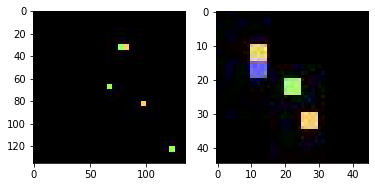

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

idx = 12
plt.subplot(1, 2, 1)
plt.imshow((trainX[idx, :]*127.5+127.5).astype(np.int32))
plt.subplot(1, 2, 2)
plt.imshow((trainY[idx, :]*127.5+127.5).astype(np.int32))

In [35]:
print(trainY[idx, :])

[[[ 14   1  19]
  [  7   0   0]
  [ 18  12   0]
  [  6   0   0]
  [  6   0   0]
  [  4   0   0]
  [  6   7   0]
  [  3  10   0]
  [  3   7   0]
  [  1   0   2]
  [  1   0  41]
  [  0   0  43]
  [  0   0  11]
  [  0   4   0]
  [  0   7   0]
  [  0   7   0]
  [  0   0   0]
  [  0   0   0]]

 [[  6   0  11]
  [ 12   2  11]
  [  6   0   4]
  [  6   0   9]
  [ 21  12  33]
  [  4   0  14]
  [  4   0   2]
  [  5   3   0]
  [  1   1   0]
  [  1   0   5]
  [  1   0  21]
  [  0   0  23]
  [  0   0  14]
  [  0   0   7]
  [  0   0   7]
  [  0   0  11]
  [  0   0   0]
  [  0   0   0]]

 [[ 12   2  10]
  [ 16   5  22]
  [  6   0  21]
  [  8   0  23]
  [ 16   7  28]
  [  3   0  18]
  [ 13   3  37]
  [  1   0  32]
  [  1   0  21]
  [  0   0   2]
  [  0   3   0]
  [  0   2   0]
  [  0   0   7]
  [  0   0  25]
  [  0   0  35]
  [  0   0  37]
  [  0   0   0]
  [  0   0   0]]

 [[  4   0   0]
  [  3   0   7]
  [  4   0  12]
  [  3   0   0]
  [  6   6   0]
  [  1   4   0]
  [  1   0   5]
  [ 10   2  43]
  

In [124]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential 

cnn=Sequential()
cnn.add(Conv2D(16,kernel_size=3,strides=1,padding='same',input_shape=(270, 270, 3))) # (270, 270, 16)
cnn.add(MaxPool2D(pool_size=2,strides=3)) # (90, 90, 16)
cnn.add(Conv2D(32,kernel_size=5,strides=1,padding='valid')) #(86, 86, 32)
cnn.add(Conv2D(64,kernel_size=7,strides=1,padding='valid'))
# (80, 80, 64) 
cnn.add(MaxPool2D(pool_size=2,strides=2)) #(40, 40, 16)
cnn.add(Conv2D(128,kernel_size=5,strides=1,padding='valid')) #(36, 36, 128)
cnn.add(MaxPool2D(pool_size=2,strides=2)) # (18, 18, 32)
cnn.add(Conv2D(256,kernel_size=3,strides=1,padding='valid')) #(16, 16, 256)
cnn.add(MaxPool2D(pool_size=2,strides=2)) # (8, 8, 64)
cnn.add(Conv2D(512,kernel_size=3,strides=1,padding='valid'))
#(6, 6, 512)
cnn.add(Conv2DTranspose(180, 5, strides=1, padding='valid',activation='relu')) #(10, 10, 90)
# cnn.add(BatchNormalization())
cnn.add(Conv2DTranspose(42, 3, strides=2, padding='valid',activation='relu', kernel_initializer='glorot_normal'))
 #(21, 21, 21)
cnn.add(Conv2DTranspose(12, 5, strides=2, padding='valid',activation='relu', kernel_initializer='glorot_normal'))
 #(23, 23, 100)
cnn.add(Conv2DTranspose(3, 3, strides=2, padding='same',activation='relu', kernel_initializer='glorot_normal'))
# lenet.add(Conv2D(128,kernel_size=3,strides=1,padding='valid')) #(12, 12, 128)
# lenet.add(Conv2D(256,kernel_size=3,strides=2,padding='valid')) #(5, 5, 256)


In [3]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential 

cnn=Sequential()
cnn.add(Conv2D(6,kernel_size=3,strides=1,padding='same',input_shape=(135, 135, 3))) # (135, 135, 16)
cnn.add(Conv2D(16,kernel_size=5,strides=2,padding='valid')) # (133, 133, 16)
cnn.add(Conv2D(32,kernel_size=7,strides=3,padding='valid')) 
cnn.add(BatchNormalization())
cnn.add(Conv2DTranspose(16, kernel_size=5, strides=2, padding='valid', kernel_initializer='glorot_normal'))
cnn.add(BatchNormalization())
cnn.add(Conv2DTranspose(6, kernel_size=7, strides=2, padding='valid', kernel_initializer='glorot_normal'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Conv2D(3, kernel_size=3, strides=1, padding='same'))

out = cnn.predict(testX[1:4, :])

print(out.shape)

(3, 45, 45, 3)


In [0]:
out = cnn.predict(testX[1:4, :])
plt.figure(figsize=(60,1))
plt.imshow((out[0, :]*127.5+127.5).astype(np.int32))

In [0]:
import tensorflow as tf
np.sum(tf.keras.losses.mean_squared_error(out[0, :], testY[1, :]).numpy())

In [0]:
from tensorflow.keras.optimizers import Adagrad

ag = Adagrad(0.1)
cnn.compile(optimizer=ag, loss='mse')

history = cnn.fit(trainX, trainY, batch_size=256, epochs=500, validation_data=[testX, testY])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


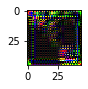

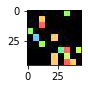

In [29]:
out = cnn.predict(testX[1:4, :])
plt.figure(figsize=(60,1))
plt.subplot(121)
plt.imshow((out[0, :]*127.5+127.5).astype(np.int32))
plt.figure(figsize=(60,1))
plt.subplot(122)
plt.imshow((testY[1, :]*127.5+127.5).astype(np.int32))

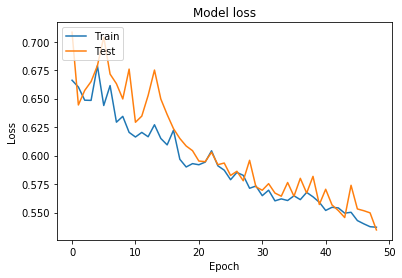

In [30]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()